Dataset taken from the Amazon Fine Food Reviews in Kaggle. It consists of reviews of fine foods from Amazon, with the data spanning 10 years and consisting of 500,000 reviews. 

Data Analysis on this dataset can provide key information to Fine Foods on what they can do to increase customer satisfaction in their Fine Food shops.

This notebook will consist of two parts: 

Exploratory Data Analysis - Analyzing the data to provide key information on reviews on Fine Food Restaurants

Machine Learning - Using the reviews to predict whether a given review is positive or negative

In [47]:
#Import neccessary modules

import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
np.set_printoptions(suppress=True)
sns.set_theme()
print("Imported modules!")

Imported modules!


In [51]:
#Import the Amazon Fine Food Reviews dataset using pandas

df = pd.read_csv('Reviews.csv')[['Text', 'Score', 'HelpfulnessNumerator', 'Summary']]
df = df.dropna()
print(df.isnull().sum())

Text                    0
Score                   0
HelpfulnessNumerator    0
Summary                 0
dtype: int64


# Exploratory Data Analysis

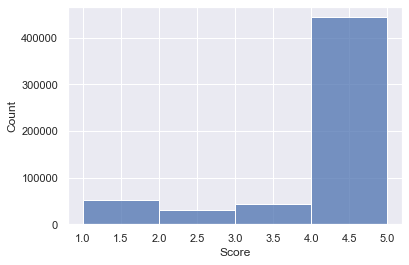

In [15]:
#Make a histogram plot showing the collection of ratings in the dataset

sns.histplot(x=df['Score'], binwidth=1)
plt.show()

Looking at the amount of reviews per rating, it's clear that the large majority of ratings given in Fine Foods are 5 stars. However, second on the list of majorities is 1, signaling that most people give ratings if they're either very satisfied or very unsatisfied. 

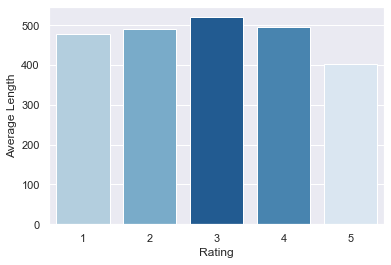

In [52]:
#Make function to get a blue color palette

def get_color_palette(data):
    pal = sns.color_palette("Blues_r", len(data))
    rank = np.array(data).argsort().argsort()
    palette = np.array(pal[::-1])[rank]
    return palette

#Make a bar plot displaying the average length of all ratings

df['Length'] = df['Text'].apply(lambda x: len(x))
average_length = [np.mean(df[df['Score']==score]['Length']) for score in [1,2,3,4,5]]
                  
sns.barplot(x=[1,2,3,4,5], y=average_length, palette=get_color_palette(average_length))
plt.xlabel('Rating')
plt.ylabel('Average Length')
plt.show()

Here, we can see that people who rate Fine Foods as either 1 or 5 tend to write the least compared to those who put their rating somewhere in between. This shows that people who are either very pleased or not pleased with Fine Foods write their reviews the shortest, and in a biased manner towards or against the food place.

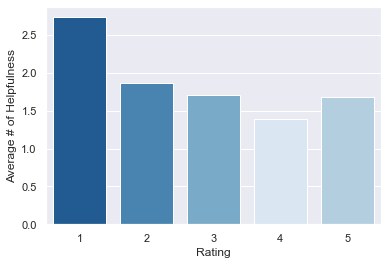

In [17]:
#Make a bar plot displaying the average amount of users helped per rating

average_help = [np.mean(df[df['Score']==score]['HelpfulnessNumerator']) for score in [1,2,3,4,5]]
                  
sns.barplot(x=[1,2,3,4,5], y=average_help, palette=get_color_palette(average_help))
plt.xlabel('Rating')
plt.ylabel('Average # of Helpfulness')
plt.show()

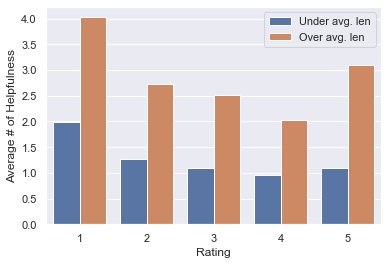

In [18]:
#Make a bar plot displaying helpfulness by the length of the review

avg = np.mean(df['Length'])

help_under = [np.mean(df[(df['Score']==score) & (df['Length'] < avg)]['HelpfulnessNumerator']) for score in [1,2,3,4,5]]
help_over = [np.mean(df[(df['Score']==score) & (df['Length'] > avg)]['HelpfulnessNumerator']) for score in [1,2,3,4,5]]

sns.barplot(x=[1,2,3,4,5]*2, y=help_under+help_over, hue=['Under avg. len']*5+['Over avg. len']*5)
plt.xlabel('Rating')
plt.ylabel('Average # of Helpfulness')
plt.show()

Inspecting the amount of users who found a review helpful per rating, negative ratings tend to be the more helpful to potential customers than positive ones. Out of all the ratings, ones that have higher than average length tend to be much more appreciated than those under. 

This shows that negative ratings are heavily impactful in deterring potential customers from going to a Fine Food place. This is especially since very positive ratings tend to be less in length, and therefore less impactful than very negative ones. 

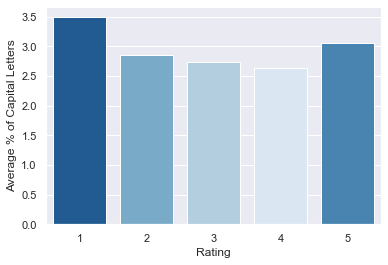

In [53]:
#Make a bar plot displaying the average amount % of capital letters of all ratings

df['Capital'] = df['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
average_capital = [np.mean(df[df['Score']==score]['Capital']) / average_length[score-1] * 100 for score in [1,2,3,4,5]]
                  
sns.barplot(x=[1,2,3,4,5], y=average_capital, palette=get_color_palette(average_capital))
plt.xlabel('Rating')
plt.ylabel('Average % of Capital Letters')
plt.show()

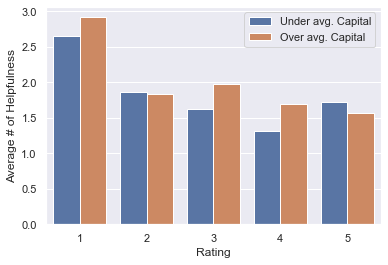

In [54]:
#Make a bar plot displaying helpfulness by the use of capital letters in the review

df['Capital_Per'] = df['Text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x))
avg = np.mean(df['Capital_Per'])

help_under = [np.mean(df[(df['Score']==score) & (df['Capital_Per'] < avg)]['HelpfulnessNumerator']) for score in [1,2,3,4,5]]
help_over = [np.mean(df[(df['Score']==score) & (df['Capital_Per'] > avg)]['HelpfulnessNumerator']) for score in [1,2,3,4,5]]

sns.barplot(x=[1,2,3,4,5]*2, y=help_under+help_over, hue=['Under avg. Capital']*5+['Over avg. Capital']*5)
plt.xlabel('Rating')
plt.ylabel('Average # of Helpfulness')
plt.show()

Capital letters are commonly used in typing to express great emotion, whether positive or negative. This explains why ratings that are either very negative or very positive use more capital letters. Inspecting reviews based on the percentage of capital letters used, there is shown little correlation between the use of capital letters and the amount of potential customers that find the review helpful. In other words, a negative review written with capital letters does not deter away a potential customer more than one with no capital letters would, and vice versa. 

(-0.5, 999.5, 749.5, -0.5)

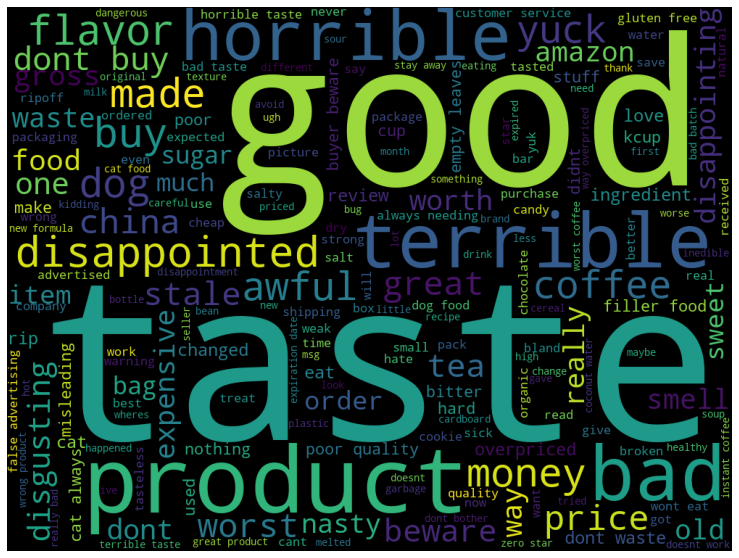

In [74]:
#Generate a word cloud for the worst rating (1)

negatives = df[df['Score'] == 1]['Summary']
total_negative = ' '.join(np.array(negatives))
total_negative = total_negative.translate(str.maketrans('', '', string.punctuation)).lower()

wordcloud = WordCloud(width = 1000, height = 750, stopwords = set(STOPWORDS)).generate(total_negative)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')

Based off of this word cloud, we can see that the majority of negative reviews include very emotionally charged words(e.g. nasty, disguisting), showing that most negative reviewers found the food to be clearly horrible, before even tasting it. There are also a large amount of phrases indicating that the price and advertising of the product was not accurate and caused them dissatisfaction. 

(-0.5, 999.5, 749.5, -0.5)

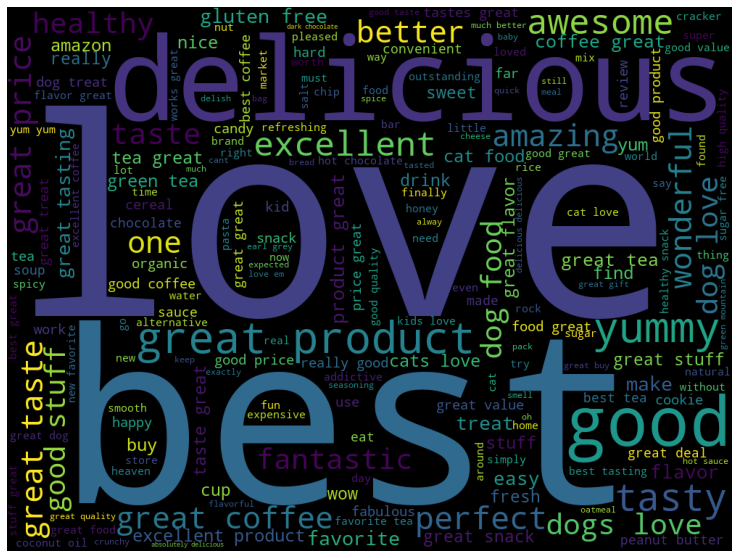

In [73]:
#Generate a word cloud for the best rating(5)

positives = df[df['Score'] == 5]['Summary']
total_positive = ' '.join(np.array(positives))
total_positive = total_positive.translate(str.maketrans('', '', string.punctuation)).lower()

wordcloud = WordCloud(width = 1000, height = 750, stopwords = set(STOPWORDS)).generate(total_positive)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')

Based off of this word cloud, it is observed that most positive reviewers find the food to be tasty. Other positive reviews often involve the words 'coffee' and 'tea', indicating that Fine Food places that provide coffee and tea gain the satisfaction of their customers. The same can be applied to providing food that can be eaten by dogs and cats. Good prices also tend to pursue customers into writing positive reviews. 

# Machine Learning

For part 2 of this Data Science Project, a Machine Learning model will be trained on the most positive and negative reviews in order to study the impact of emotional words into its predictions. The Machine Learning model will consist of Logistic Regression applied to a vectorized and normalized transformation of 10,000 1 and 5 star reviews. 

In [44]:
#Transform dataframe into data for predictive model

#Balance dataset

df = df[(df['Score'] == 1) | (df['Score'] == 5)]
df = df.groupby('Score').head(10000)

#Transform the dataset

df['Text'] = df['Text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())

#Convert to numpy arrays

X = np.array(df['Text'])
y = np.array(df['Score'])

print(len(X), len(y))

20000 20000


In [49]:
#Make a predictive model using Logistic Regression 

model = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('scale', MaxAbsScaler()),
    ('log', LogisticRegression(max_iter=10000))
])

#Get the scores on the dataset, as well as the standard deviation 

scores = cross_val_score(model, X, y, cv=5)
print(scores.mean(), scores.std())

#Fit model to data

model.fit(X, y)

#Function to make predictions

def pred_review(reviews):
    reviews = [r.translate(str.maketrans('', '', string.punctuation)).lower() for r in reviews]
    return model.predict_proba(reviews)

#Make predictions

print(pred_review(['I liked the food, would recommend to others', 'The food sucked, it tasted bad']))
print(pred_review(['I loved the food, it tasted like heaven, I would definetly recommend to others', 
                   'The food sucked really bad, it tasted absolutely and utterly trash and disguisting']))

0.90615 0.006965270992574512
[[0.12349455 0.87650545]
 [0.99213121 0.00786879]]
[[0.13471446 0.86528554]
 [0.94272662 0.05727338]]


The results of the Machine Learning model indicate that simply the use of stronger language in a review does not translate to a worse or better rating in the eyes of a potential customer. Fine Foods should not be worried about whether the 1 and 5 star reviews in their food place use emotional language or not. 

# Conclusion 

Ratings left by reviewers, especially in food places such as Fine Foods, can have a measurable impact on the amount of customers going to a restaurant. Therefore, it is extremely important for Fine Foods to understand their reviews and what to do to increase the number of positive reviews into their restaurant. 

This Data Science study discovered that negative reviews tend to be the most helpful in the eyes of potential customers, making it also important to be able to decrease the amount of negative reviews going into a restaurant. Although, Fine Foods don't have to worry about whether negative reviews use strong language, as it tends not to deter customers away more than a regular negative review. 

Analyzing 500,000 Fine Food Reviews, most people post negatives reviews because:

1. The food given to them was absolutely awful and presented horribly
2. The food given to them was overpriced and not as advertised.

Therefore, in order to decrease dissatisfaction among customers, Fine Foods can:

1. Initiate more food checking measures to ensure all food coming out of their restaurant is fresh
2. Decrease prices on food not ordered often
3. Make their advertisements more realistic

On the other hand, most people post positive reviews because:

1. They found the food presented well and delicious
2. The food was also enjoyed by their dogs and cats
3. Good tea and coffee were provided to them

Therefore, in order to increase satisfaction among customers, Fine Foods can:

1. Routinely taste their menu
2. Make interview processes harder to hire good chefs
3. Make sure their food can be eaten and enjoyed by dogs and cats
4. Provide tea and coffee if not already provided

The reviews of a restaurant can have a large both negative and positive impact on its profits. However, there are ways listed above for restaurants such as Fine Foods to ensure satisfaction among their customers. 